<a href="https://colab.research.google.com/github/NewAnik/DataScience/blob/master/Anomaly_Detection_Using_PyTorch_Autoencoder_and_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
                       
import pandas as pd                       
import matplotlib.pyplot as plt                       
import numpy as np

In [ ]:
df = pd.read_csv('mnist_test.csv')

In [ ]:
df.shape

(10000, 785)

In [ ]:
anom = df[:1000]
clean = df[1000:]

In [ ]:
for i in range(len(anom)):
    # select row from anom
    row = anom.iloc[i]
    # iterate through each element in row
    for i in range(len(row)-1):
        # add noise to element
        row[i+1] = min(255, row[i+1]+random.randint(100,200))

In [ ]:
anom.head(5)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,...,27x17,27x18,27x19,27x20,27x21,27x22,27x23,27x24,27x25,27x26,27x27,27x28,28x1,28x2,28x3,28x4,28x5,28x6,28x7,28x8,28x9,28x10,28x11,28x12,28x13,28x14,28x15,28x16,28x17,28x18,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,1,176,124,170,161,144,177,199,179,123,137,183,124,143,142,168,182,163,187,115,106,166,143,144,156,107,138,190,192,121,148,196,115,128,191,105,128,120,181,106,...,194,111,179,200,129,160,194,199,159,175,135,148,173,172,130,152,171,148,189,184,167,150,139,136,100,196,125,113,121,123,129,162,162,157,103,129,104,197,117,164
1,1,121,103,138,165,128,108,133,148,120,120,131,191,192,197,195,162,200,159,195,100,120,194,127,167,199,107,160,166,194,130,180,200,180,110,193,141,179,114,165,...,116,124,108,198,108,133,163,184,188,138,188,183,150,195,126,135,119,105,172,132,154,136,153,165,182,150,129,138,135,151,195,190,107,194,114,170,150,121,192,107
2,1,116,182,187,113,142,191,130,191,156,178,182,175,166,156,186,122,132,178,104,122,159,167,143,108,145,130,159,153,146,196,114,133,184,167,115,128,199,122,187,...,184,173,146,152,103,195,146,146,105,102,177,126,108,194,103,144,126,135,134,175,136,106,121,196,118,144,134,181,176,136,102,158,119,111,161,126,127,173,161,118
3,1,162,200,102,186,177,171,200,150,134,182,122,133,195,193,111,183,195,100,185,145,110,168,170,109,187,150,153,127,156,158,131,118,104,120,184,172,121,151,152,...,117,135,161,197,115,176,124,191,124,112,171,181,115,186,108,175,134,130,107,192,158,154,158,194,134,173,191,145,117,182,164,196,127,195,157,168,122,113,192,149
4,1,133,152,198,168,154,126,162,145,133,154,185,181,140,110,195,180,124,114,105,195,179,163,176,165,140,127,110,163,104,175,124,170,196,109,175,168,112,182,134,...,157,108,135,134,139,135,137,114,190,100,181,106,163,118,123,170,152,134,184,128,200,107,155,145,178,170,158,137,139,120,122,133,101,143,110,188,194,140,144,164


In [ ]:
anom['label'] = 1
clean['label'] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
an_test = pd.concat([anom, clean])  # join
an_test.sample(frac=1)              # shuffle
an_test.to_csv('anom.csv')          # save

In [ ]:
import torch.nn as nn
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU()
        )
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

In [ ]:
import torch
import time
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from datetime import timedelta

In [ ]:
batch_size = 32
lr = 1e-2         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9   
epochs = 15

In [ ]:
class Loader(torch.utils.data.Dataset):
    def __init__(self):
        super(Loader, self).__init__()
        self.dataset = ''
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        row = row.drop(labels={'label'})
        data = torch.from_numpy(np.array(row)/255).float()
        return data
    
class Train_Loader(Loader):
    def __init__(self):
        super(Train_Loader, self).__init__()
        self.dataset = pd.read_csv(
                       'mnist_train.csv',
                       index_col=False
                       )

In [ ]:
train_set = Train_Loader()
train_ = torch.utils.data.DataLoader(
            train_set,
            batch_size=batch_size,
            shuffle=True,
            num_workers=20,
            pin_memory=True,
            drop_last=True
        )

In [ ]:
metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AE()
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

In [ ]:
model.train()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for bx, (data) in enumerate(train_):
        sample = model(data.to(device))
        loss = criterion(data.to(device), sample)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(train_set)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    print('-----------------------------------------------')
    print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch+1,epochs,epoch_loss))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))


-----------------------------------------------
[EPOCH] 1/15
[LOSS] 0.0033416229592015344
Epoch Complete in 0:00:54.402771
-----------------------------------------------
[EPOCH] 2/15
[LOSS] 0.0032201549441864094
Epoch Complete in 0:00:53.572782
-----------------------------------------------
[EPOCH] 3/15
[LOSS] 0.0030881537494560083
Epoch Complete in 0:00:53.782264
-----------------------------------------------
[EPOCH] 4/15
[LOSS] 0.0029453418493270876
Epoch Complete in 0:00:53.398341
-----------------------------------------------
[EPOCH] 5/15
[LOSS] 0.0028070713358620803
Epoch Complete in 0:00:53.676675
-----------------------------------------------
[EPOCH] 6/15
[LOSS] 0.0026962923267235357
Epoch Complete in 0:00:53.291606
-----------------------------------------------
[EPOCH] 7/15
[LOSS] 0.002629264725248019
Epoch Complete in 0:00:52.874131
-----------------------------------------------
[EPOCH] 8/15
[LOSS] 0.0025977499949435393
Epoch Complete in 0:00:54.070278
-----------------

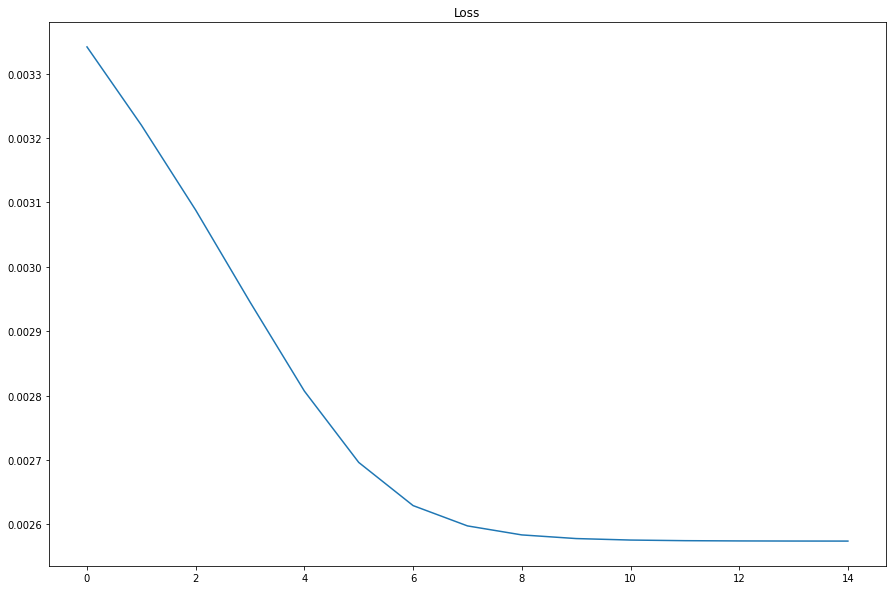

In [ ]:
_, ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('Loss')
ax.plot(metrics['train_loss'])

In [ ]:
model.eval()
loss_dist = []
anom = pd.read_csv('anom.csv', index_col=[0])
#for bx, data in enumerate(test_):
for i in range(len(anom)):
    data = torch.from_numpy(np.array(anom.iloc[i][1:])/255).float()
    sample = model(data.to(device))
    loss = criterion(data.to(device), sample)
    loss_dist.append(loss.item())

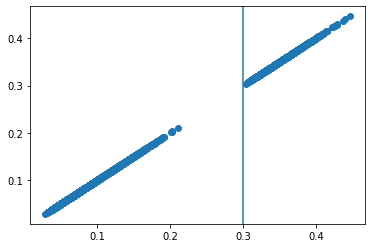

In [ ]:
loss_sc = []
for i in loss_dist:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(0.3, 0.0, 1)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


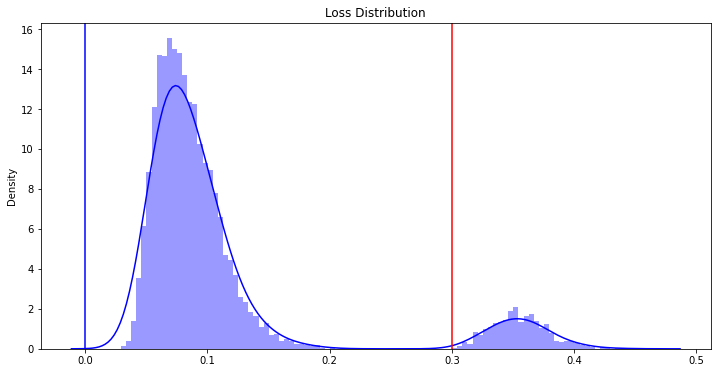

In [ ]:
lower_threshold = 0.0
upper_threshold = 0.3
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(loss_dist,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

In [ ]:
df = pd.read_csv('anom.csv', index_col=[0])
ddf = pd.DataFrame(columns=df.columns)
tp = 0
fp = 0
tn = 0
fn = 0
total_anom = 0
for i in range(len(loss_dist)):
    total_anom += df.iloc[i]['label']
    if loss_dist[i] >= upper_threshold:
        n_df = pd.DataFrame([df.iloc[i]])
        n_df['loss'] = loss_dist[i]
        ddf = pd.concat([df,n_df], sort = True)
        if float(df.iloc[i]['label']) == 1.0:
            tp += 1
        else:
            fp += 1
    else:
        if float(df.iloc[i]['label']) == 1.0:
            fn += 1
        else:
            tn += 1
print('[TP] {}\t[FP] {}\t[MISSED] {}'.format(tp, fp, total_anom-tp))
print('[TN] {}\t[FN] {}'.format(tn, fn))

[TP] 1000	[FP] 0	[MISSED] 0
[TN] 9000	[FN] 0


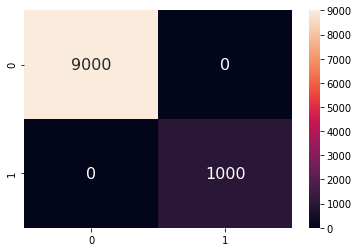

In [ ]:
conf = [[tn,fp],[fn,tp]]
plt.figure()
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')